In [106]:
using SpecialFunctions
using QuantumOptics

function fidelity(ρ, σ)
    tr(sqrt(sqrt(ρ) * σ * sqrt(ρ)))^(1/2)
end

function R(n::Int64, m::Int64, ρ::Float64)
    if (n - m) % 2 != 0
        0
    else
        function summand(k)
            n = big(n)
            k = big(k)
            (-1)^k * factorial(n-k)/(factorial(k)*factorial(Int((n+m)/2) - k)*factorial(Int((n-m)/2) - k))*(ρ)^(n-2*k)
        end
        mapreduce(summand, +, Array(range(0, stop=Int((n-m)/2), step=1)))
    end
end

function plot_across_unit_disk(f, discretization)
    x = y = Array(range(-1, 1, length=discretization))
    z = Array{typeof(f(0.,0.))}(UndefInitializer(), length(x), length(y))
    for (i, xx) in enumerate(x)
        for (j, yy) in enumerate(y)
            print("Plotting cell" * string(xx) * "," * string(yy) * "...")
            if xx^2 + yy^2 > 1
                if typeof(f(0.,0.)) == Tuple{Float64,Float64}
                    z[i, j] = (0.,0.)
                else
                    z[i, j] = 0.
                end
            else
                ρ = sqrt(xx^2 + yy^2)
                ϕ = atan(yy, xx)
                res = f(ρ, ϕ)
                z[i, j] = res
            end
        end
    end
    x, y, z
end

function unpack_zernike(zernike_coefficients_even, zernike_coefficients_odd, ρ, ω, t)
    eventuples = []
    for zeven in zernike_coefficients_even
        neven = length(zeven) - 1
        Peven = reduce(+, [zeven[i] * R(neven, i-1, ρ) for i in Array(range(1, neven + 1, step=1))])
        rotationeven = - (neven) * ω * t
        push!(eventuples, (neven, Peven, rotationeven))
    end
    oddtuples = []
    for zodd in zernike_coefficients_odd
        nodd = length(zodd) - 1
        Podd = reduce(+, [zodd[i] * R(nodd, i-1, ρ) for i in Array(range(1, nodd + 1, step=1))])
        rotationodd = - (nodd) * ω * t
        push!(oddtuples, (nodd, Podd, rotationodd))
    end
    eventuples, oddtuples
end

toarray(s::Union{Set, Array}) = [toarray.(s)...]
toarray(v::Number) = v

toarray (generic function with 2 methods)

In [2]:
function H_odf(ρ, ϕ, t, zernike_coefficients_even, zernike_coefficients_odd, U, ψ, μ, ω)
    eventuples, oddtuples = unpack_zernike(zernike_coefficients_even, zernike_coefficients_odd, ρ, ω, t)
    eventerm = oddterm = 0
    if length(eventuples) > 0
        eventerm = mapreduce(x->x[2]*cos(x[1]*ϕ + x[3]), +, eventuples)
    end
    if length(oddtuples) > 0
        oddterm = mapreduce(x->x[2]*sin(x[1]*ϕ + x[3]), +, oddtuples)
    end
    U * cos(-μ*t + ψ + eventerm + oddterm) 
end

H_odf (generic function with 1 method)

In [3]:
function H_odf_RWA(ρ, ϕ, t, zernike_coefficients_even, zernike_coefficients_odd, U, ψ, ω, m)
    zernike_coefficients_even = filter(x -> length(x) - 1 == m, zernike_coefficients_even)
    zernike_coefficients_odd = filter(x -> length(x) - 1 == m, zernike_coefficients_odd)
    eventuples, oddtuples = unpack_zernike(zernike_coefficients_even, zernike_coefficients_odd, ρ, ω, t) 
    p = q = 0
    if length(eventuples) > 0
        p = eventuples[1][2]
    end
    if length(oddtuples) > 0
        q = oddtuples[1][2]
    end
    U * besselsum(p, q, -m * ϕ + ψ)
end    

function H_odf_RWA_small(ρ, ϕ, t, zernike_coefficients_even, zernike_coefficients_odd, U, ψ, ω, m)
    zernike_coefficients_even = filter(x -> length(x) - 1 == m, zernike_coefficients_even)
    zernike_coefficients_odd = filter(x -> length(x) - 1 == m, zernike_coefficients_odd)
    eventuples, oddtuples = unpack_zernike(zernike_coefficients_even, zernike_coefficients_odd, ρ, ω, t)    
    p = q = 0
    if length(eventuples) > 0
        p = eventuples[1][2]
    end
    if length(oddtuples) > 0
        q = oddtuples[1][2]
    end
    U/2 * (p * sin(m*ϕ - ψ) - q * cos(m*ϕ - ψ))
end    

H_odf_RWA_small (generic function with 1 method)

In [4]:
function besselsum(p, q, θ)
    ret = besselj(0, p)*besselj(-1, q)*cos(θ)
    i = 1
    nextterm = 1
    while i < 100
        nextterm = besselterm(i, p, q, θ)
        i += 1
        ret += nextterm
    end
    ret
end

function besselterm(n, p, q, θ)
    besselj(n, p)*besselj(-(n+1), q)*cos(n*π/2 + θ) + besselj(-n, p)*besselj(n-1, q)*cos(-n*π/2 + θ) #?
end

besselterm (generic function with 1 method)

In [6]:
Γ = 1/62
ω = 2*π*180E3
#ω = 2*π*43.8E3
μ = ω
U = 2*π*10E3
θ = 0.;

In [109]:
b = SpinBasis(1//2)
ψ0 = 1/sqrt(2) * (spindown(b) + spinup(b))
evolution_time = 110.0E-6
step_size = evolution_time/100
T = [0.0:step_size:evolution_time;]
zernikeeven = []#[[0.], [0., 1.]];
zernikeodd = [[0.], [0., 1.]];

In [8]:
ρ = 1.
ϕ = 0.
H(t, _) = H_odf(ρ, ϕ, t, zernikeeven, zernikeodd, U, θ, μ, ω)*sigmaz(b), [sigmam(b)], [dagger(sigmam(b))]
tout, ψ = timeevolution.master_dynamic(T, ψ0, H; rates=[Γ])

# Measure in the x basis
excitation = Real.(expect(sigmax(b), ψ));

In [9]:
H(t, _) = H_odf_RWA(ρ, ϕ, t, zernikeeven, zernikeodd, U, θ, ω, 1)*sigmaz(b), [sigmam(b)], [dagger(sigmam(b))]
tout, ψ = timeevolution.master_dynamic(T, ψ0, H; rates=[Γ])

# Measure in the x basis
rwa = Real.(expect(sigmax(b), ψ));

In [10]:
H(t, _) = H_odf_RWA_small(ρ, ϕ, t, zernikeeven, zernikeodd, U, θ, ω, 1)*sigmaz(b), [sigmam(b)], [dagger(sigmam(b))]
tout, ψ = timeevolution.master_dynamic(T, ψ0, H; rates=[Γ])

# Measure in the x basis
small = Real.(expect(sigmax(b), ψ));

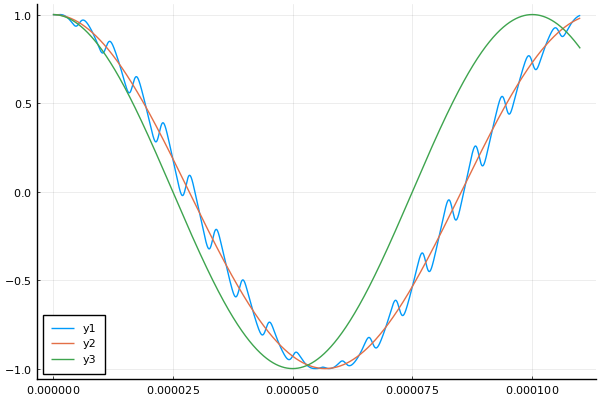

In [11]:
using Plots; pyplot()
plot(T, [excitation, rwa, small])

In [12]:
function evolution_evaluator_factory(ψ0, T, zernikeeven, zernikeodd, U, ψ, μ, ω, b)
    function evaluator(ρ, ϕ)
        H(t, _) = H_odf(ρ, ϕ, t, zernikeeven, zernikeodd, U, ψ, μ, ω)*sigmaz(b), [sigmam(b)], [dagger(sigmam(b))]
        _, ψTARGET = timeevolution.master_dynamic(T, ψ0, H; rates=[Γ])
        last(ψTARGET)
    end
end
exact_evolution_evaluator = evolution_evaluator_factory(ψ0, T, zernikeeven, zernikeodd, U, θ, μ, ω, b)

function rwa_evolution_evaluator_factory(ψ0, T, zernikeeven, zernikeodd, U, ψ, ω, b)
    function evaluator(ρ, ϕ)
        H(t, _) = H_odf_RWA(ρ, ϕ, t, zernikeeven, zernikeodd, U, ψ, ω, 1)*sigmaz(b), [sigmam(b)], [dagger(sigmam(b))]
        _, ψTARGET = timeevolution.master_dynamic(T, ψ0, H; rates=[Γ])
        last(ψTARGET)
    end
end
rwa_evolution_evaluator = rwa_evolution_evaluator_factory(ψ0, T, zernikeeven, zernikeodd, U, θ, ω, b)

function rwa_small_evolution_evaluator_factory(ψ0, T, zernikeeven, zernikeodd, U, ψ, ω, b)
    function evaluator(ρ, ϕ)
        H(t, _) = H_odf_RWA_small(ρ, ϕ, t, zernikeeven, zernikeodd, U, ψ, ω, 1)*sigmaz(b), [sigmam(b)], [dagger(sigmam(b))]
        _, ψTARGET = timeevolution.master_dynamic(T, ψ0, H; rates=[Γ])
        last(ψTARGET)
    end
end
rwa_small_evolution_evaluator = rwa_small_evolution_evaluator_factory(ψ0, T, zernikeeven, zernikeodd, U, θ, ω, b)


function infidelity_across_disk(F1, F2)
    function infidelity_polar(ρ, ϕ)
        ψ1 = F1(ρ, ϕ).data
        ψ2 = F2(ρ, ϕ).data
        1 - real(fidelity(ψ1, ψ2))
    end
end

infidelity_across_disk (generic function with 1 method)

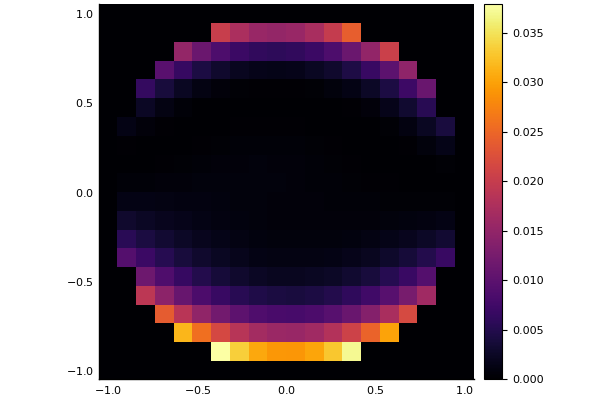

In [13]:
discretization = 20
plot(heatmap(plot_across_unit_disk(infidelity_across_disk(exact_evolution_evaluator, rwa_small_evolution_evaluator), discretization)), aspectratio = true)

# Something is incredibly sensitive to the frequency, increasing it by a factor of ten supressess the infidelity by several orders of magnitude

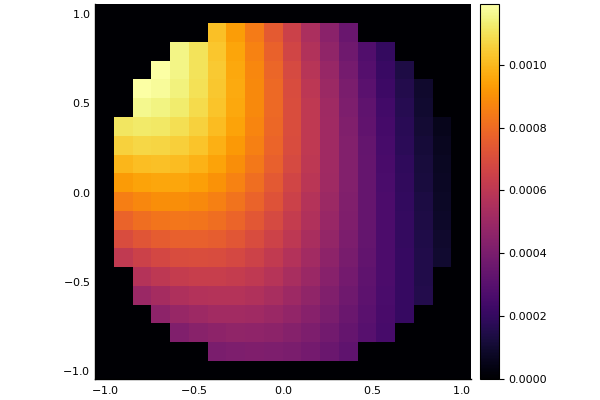

In [14]:
plot(heatmap(plot_across_unit_disk(infidelity_across_disk(exact_evolution_evaluator, rwa_evolution_evaluator), discretization)), aspectratio = true)

# Now we want to support applying multiple orders

In [15]:
function sequential_exact_evolution_evaluator_factory(ψ0, T, zernikeeven, zernikeodd, U, θ, ω, b)
    """Apply all the zernike coefficients given, in order, for time T each."""
    lengthseven = map(x -> length(x), zernikeeven)
    lengthsodd = map(x -> length(x), zernikeodd)
    orders = sort(toarray(union(Set(lengthseven), Set(lengthsodd))))
    function evaluator(ρ, ϕ)
        # Keep this in the definition :).
        ψ = ψ0
        for order in orders
            μ = order * ω
            H(t, _) = H_odf(ρ, ϕ, t, zernikeeven, zernikeodd, U, θ, μ, ω)*sigmaz(b), [sigmam(b)], [dagger(sigmam(b))]
            _, ψ = timeevolution.master_dynamic(T, ψ, H; rates=[Γ])
            ψ = last(ψ)
        end
        ψ
    end
end

sequential_exact_evolution_evaluator_factory (generic function with 1 method)

In [16]:
function Z_polynomial(n::Int64)
    """Coefficients for Z_j^0, from low degree to high degree."""
    function summand(k)
        n = big(n)
        k = big(k)
        # The normalization in the front seems right, according to Wikipedia.
        (-1)^k * factorial(n-k)/(factorial(k)*factorial(Int(n/2) - k)*factorial(Int((n)/2) - k))
    end
    res = []
    for i in Array(range(0, stop=Int(n/2), step=1))
        push!(res, summand(i))
    end
    reverse(res)
end

Z_polynomial (generic function with 1 method)

In [17]:
using Combinatorics
function gaussian_coefficients(n, σ)
    """Integral of a Gaussian against an nth order polynomial from 0 to 1, times 2pi. n must be odd."""
    total = BigFloat(0)
    n = big(n)
    total = 1/2 * σ^2 * doublefactorial(n - 1) * (σ^2/2)^((n-1)/2)
    for i in range(0, Int64((n-1)/2), step = 1)
        total += -1/2 * σ^2 * exp(-1/σ^2) * (σ^2/2)^(i) * doublefactorial(n-1)/doublefactorial(n - 1 - 2 * i)
    end
    2 * π * total
end

gaussian_coefficients (generic function with 1 method)

In [18]:
# I think we have numerical errors... for large σ

In [83]:
function zernike_gaussian_coefficients(σ, m)
    """Try to reconstruct a gaussian, using Zernike polynomials up to order m"""
    coeffs = []
    for n in collect(2 * range(0, m/2, step=1))
        coeff = 0
        for (i, coefficient) in enumerate(Z_polynomial(Int64(n)))
            scalar = sqrt(2 * n + 2)
            if n == 0
                scalar /= sqrt(2)
            end
            coeff += coefficient * gaussian_coefficients(2 * i - 1, σ) * scalar
        end
        push!(coeffs, coeff)
    end
    coeffs /= sum([coeff * (-1)^(n+1) for (n, coeff) in enumerate(coeffs)])
end

function reconstruct_gaussian(ρ, σ, m)
    """Try to reconstruct a gaussian, using Zernike polynomials up to order m"""
    total = BigFloat(0)
    coeffs = zernike_gaussian_coefficients(σ, m)
    for (i, coeff) in enumerate(coeffs)
        total += coeff * (R(Int64(2*i - 2), 0, ρ)) # THIS WAS THE PROBLEM. MAKE SURE YOU'RE DOING THE MATH RIGHT.
    end
    total
end

reconstruct_gaussian (generic function with 1 method)

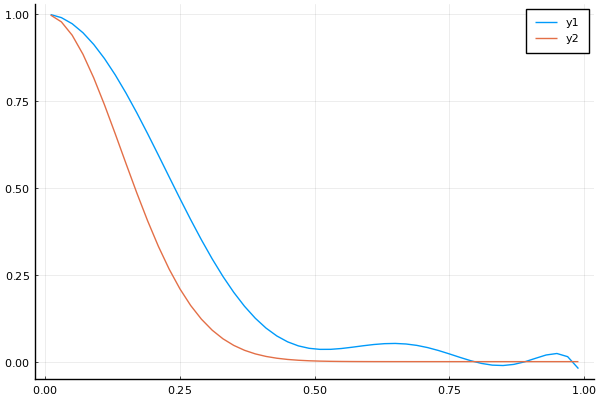

In [94]:
using Plots
max_n = 10
max_ρ = 1
min_ρ = .01
σ = .2
ρs = range(min_ρ, max_ρ, step=max_ρ/50)
ys = [reconstruct_gaussian(ρ, σ, max_n) for ρ in ρs];
target = [exp(-ρ^2/σ^2) for ρ in ρs]
plot(ρs, [ys, target])

In [95]:
zernikeeven = [vcat([0 for _ in range(1, 2*i - 2, step=1)], [el]) for (i, el) in enumerate(zernike_gaussian_coefficients(σ, max_n))];

In [98]:
sequential_exact_evolution_evaluator = sequential_exact_evolution_evaluator_factory(ψ0, T, zernikeeven, [], U, θ, ω, b)

(::var"#evaluator#31"{Ket{SpinBasis{1//2,Int64},Array{Complex{Float64},1}},Array{Float64,1},Array{Array{BigFloat,1},1},Array{Any,1},Float64,Float64,Float64,SpinBasis{1//2,Int64},Array{Int64,1}}) (generic function with 1 method)

In [111]:
function gaussian_spin_profile(ρ, ϕ)
    ψ0 = 1/sqrt(2) * (spindown(b) + spinup(b))
    H(t, _) = exp(-ρ^2/σ^2) * sigmaz(b), [sigmam(b)], [dagger(sigmam(b))]
    _, ψ = timeevolution.master_dynamic(T, ψ0, H; rates=[Γ])
    last(ψ)
end

gaussian_spin_profile (generic function with 1 method)

In [ ]:
discretization = 10
plot(heatmap(plot_across_unit_disk(infidelity_across_disk(gaussian_spin_profile, sequential_exact_evolution_evaluator), discretization)), aspectratio = true)